# Sheet 5

In [1]:
import os
import pandas as pd

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [ ]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

AssertionError: The path to the datasets does not exist.

In [ ]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

## 3 Log-sum-exp and soft(arg)max
### (b)

[0.09003057317038046, 0.24472847105479767, 0.6652409557748219]
[0.09003057317038046, 0.24472847105479764, 0.6652409557748219]
[2.061060046209062e-09, 4.539786860886666e-05, 0.9999546000703311]


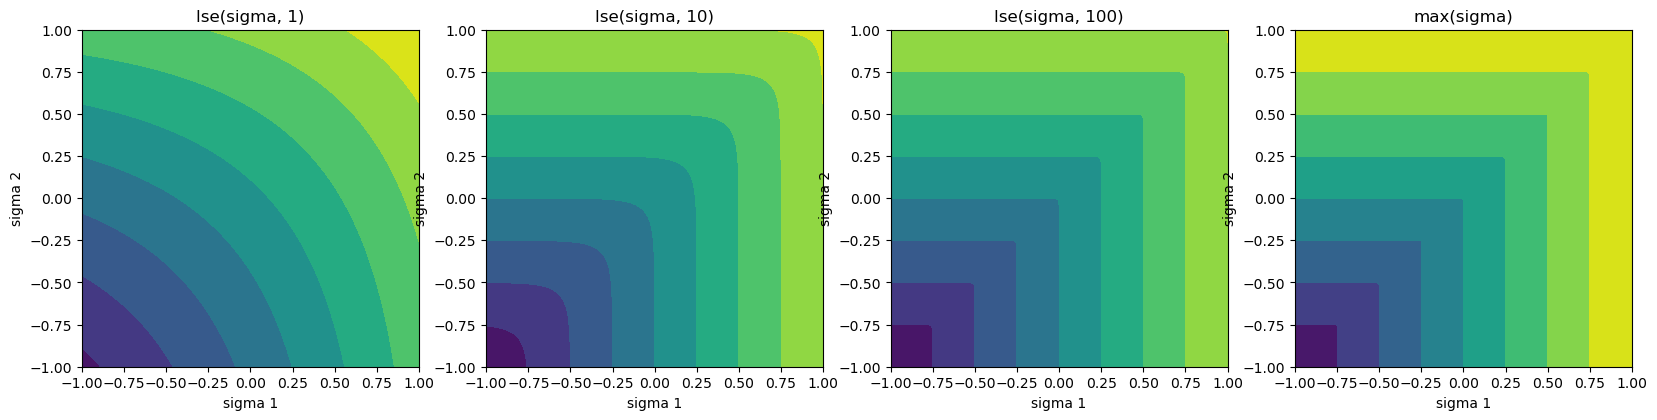

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

def softmax(sigma, lam):
    denom = sum([np.exp(lam*s) for s in sigma])
    return [np.exp(lam*s) / denom for s in sigma]

def lse(sigma, lam):
    return np.log(sum([np.exp(lam*s) for s in sigma])) / lam


print(softmax([1, 2, 3], 1))
print(softmax([11, 12, 13], 1))
print(softmax([10, 20, 30], 1))


fig, ax = plt.subplots(1, 4)
s1_all = np.linspace(-1, 1, 100)
s2_all = np.linspace(-1, 1, 100)
for i, lam in enumerate([1, 10, 100]):
    s1_grid, s2_grid = np.meshgrid(s1_all, s2_all) 
    #lse_val = np.array([lse([s1, s2], lam) for s1, s2 in zip(s1_grid, s2_grid)])
    lse_val = np.array([[lse([s1, s2], lam) for s1 in s1_all] for s2 in s2_all])
    #lse_val = np.array([[lse([s1, s2], lam) for s1 in s1_all] for s2 in s2_all])
    #cs = ax[i].contourf(s1_all, s2_all, lse_val)
    cs = ax[i].contourf(s1_grid, s2_grid, lse_val)
    ax[i].set_xlabel('sigma 1')
    ax[i].set_ylabel('sigma 2')
    ax[i].set_title(f'lse(sigma, {lam})')

    #ax[i].clabel(cs, inline=True, fontsize=10)
    ax[i].set_aspect('equal', adjustable='box')

lse_val = np.array([[max(s1, s2) for s1 in s1_all] for s2 in s2_all])
ax[3].contourf(s1_grid, s2_grid, lse_val)
ax[3].set_xlabel('sigma 1')
ax[3].set_ylabel('sigma 2')
ax[3].set_title('max(sigma)')

#ax[i].clabel(cs, inline=True, fontsize=10)
ax[3].set_aspect('equal', adjustable='box')


fig.set_figwidth(20)
plt.show()

### (c)

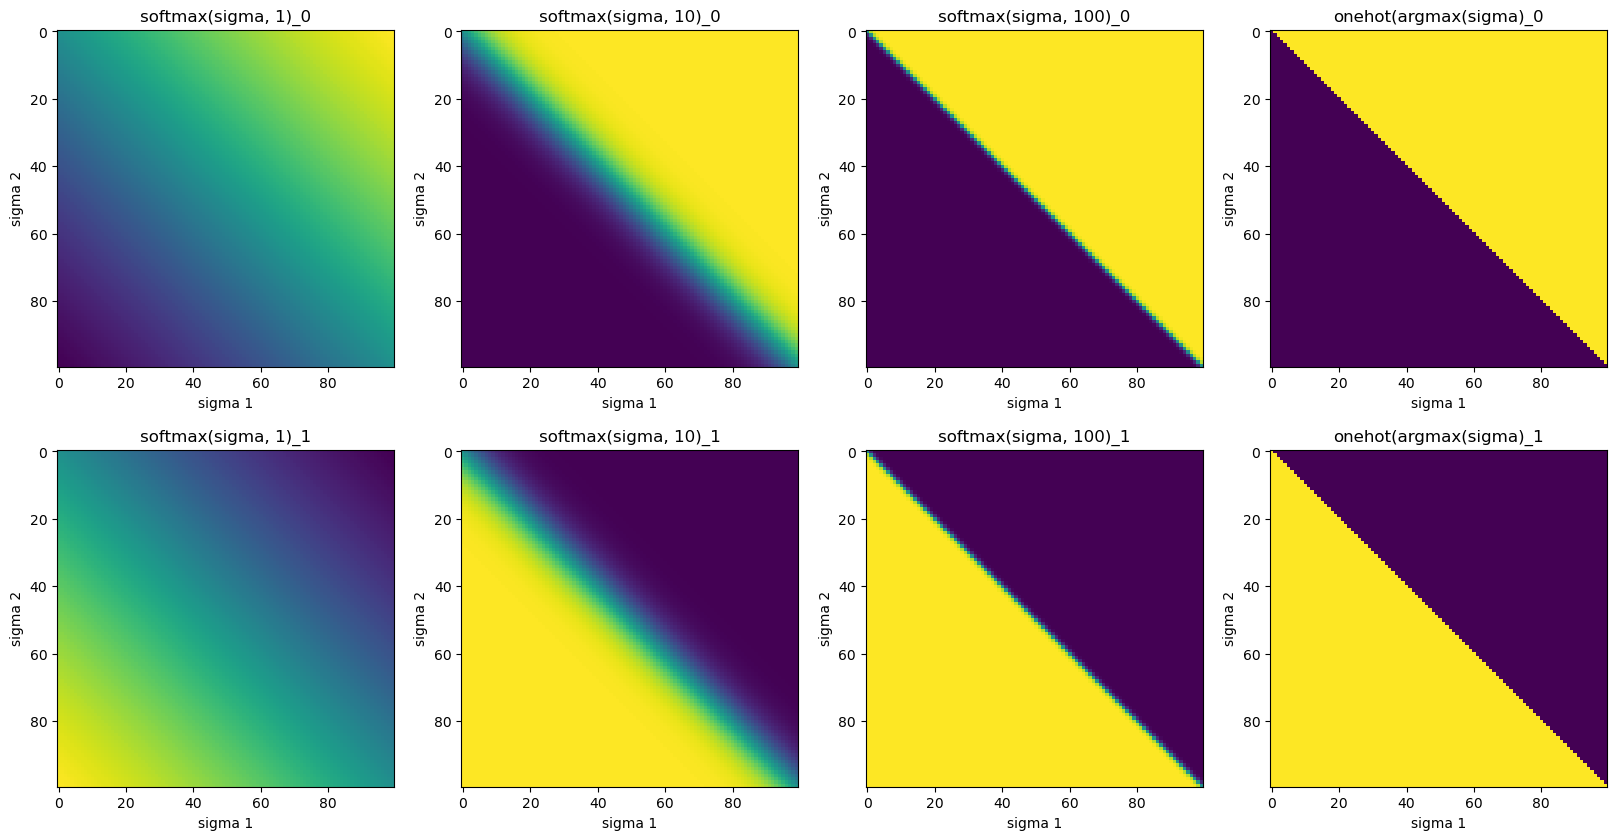

In [ ]:
fig, ax = plt.subplots(2, 4)
for i, lam in enumerate([1, 10, 100]):
    for j in [0, 1]:
        softmax_val = np.array([[softmax([s1, s2], lam)[j] for s1 in s1_all] for s2 in s2_all])
        ax[j, i].imshow(softmax_val)
        ax[j, i].set_xlabel('sigma 1')
        ax[j, i].set_ylabel('sigma 2')
        ax[j, i].set_title(f'softmax(sigma, {lam})_{j}')
        ax[j, i].set_aspect('equal', adjustable='box')

    #ax[i].clabel(cs, inline=True, fontsize=10)

#lse_val = np.array([[max(s1, s2) for s1 in s1_all] for s2 in s2_all])
#ax[3].contourf(s1_grid, s2_grid, lse_val)
#ax[3].set_xlabel('sigma 1')
#ax[3].set_ylabel('sigma 2')
#ax[3].set_title('max(sigma)')
#
##ax[i].clabel(cs, inline=True, fontsize=10)
#ax[3].set_aspect('equal', adjustable='box')
for j in [0, 1]:
    onehot_val = np.array([[j if s1 <= s2 else 1 - j for s1 in s1_all] for s2 in s2_all])
    ax[j, 3].imshow(onehot_val)
    ax[j, 3].set_xlabel('sigma 1')
    ax[j, 3].set_ylabel('sigma 2')
    ax[j, 3].set_title(f'onehot(argmax(sigma)_{j}')
    ax[j, 3].set_aspect('equal', adjustable='box')


fig.set_figwidth(20)
fig.set_figheight(10)

## 4 Linear regions of MLPs

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ShallowNet(
  (fc1): Linear(in_features=2, out_features=20, bias=True)
  (fc2): Linear(in_features=20, out_features=1, bias=True)
)
(500, 500)


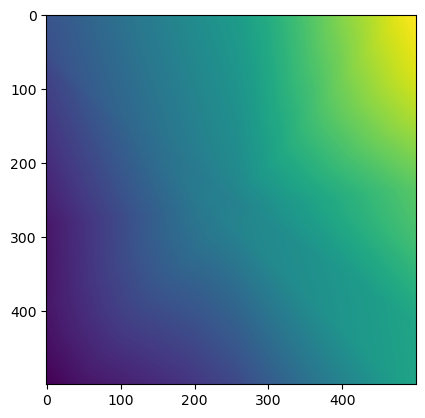

In [44]:
class ShallowNet(nn.Module):
    def __init__(self):
        super(ShallowNet, self).__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 1)

    # x represents our data
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)

        x = self.fc2(x)
        return x

shallow_nn = ShallowNet()
print(shallow_nn)

fig, ax = plt.subplots(1, 1)
x1_all = np.linspace(-10, 10, 500)
x2_all = np.linspace(-10, 10, 500)

shallow_val = np.array([[shallow_nn(torch.tensor([x1, x2], dtype=torch.float32)).item() for x1 in x1_all] for x2 in x2_all])
print(shallow_val.shape)

ax.imshow(shallow_val)


In [41]:

import matplotlib as mpl

2
(500, 500)


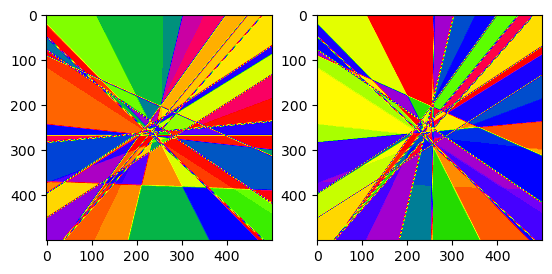

In [46]:
shallow_gradient = np.gradient(shallow_val)
print(len(shallow_gradient))
print(shallow_gradient[0].shape)

fig, ax = plt.subplots(1, 2)
for i in range(2):
    ax[i].imshow(shallow_gradient[i], cmap=mpl.colormaps['prism'])

plt.show()

DeepNet(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=5, bias=True)
  (fc3): Linear(in_features=5, out_features=5, bias=True)
  (fc4): Linear(in_features=5, out_features=5, bias=True)
  (fc5): Linear(in_features=5, out_features=1, bias=True)
)
(500, 500)


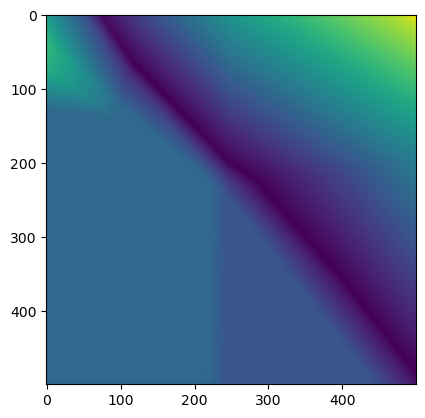

In [48]:
class DeepNet(nn.Module):
    def __init__(self):
        super(DeepNet, self).__init__()
        self.fc1 = nn.Linear(2, 5)
        self.fc2 = nn.Linear(5, 5)
        self.fc3 = nn.Linear(5, 5)
        self.fc4 = nn.Linear(5, 5)
        self.fc5 = nn.Linear(5, 1)

    # x represents our data
    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.relu(x)
        x = self.fc4(x)
        x = F.relu(x)

        x = self.fc5(x)
        return x

deep_nn = DeepNet()
print(deep_nn)

fig, ax = plt.subplots(1, 1)
x1_all = np.linspace(-10, 10, 500)
x2_all = np.linspace(-10, 10, 500)

deep_val = np.array([[deep_nn(torch.tensor([x1, x2], dtype=torch.float32)).item() for x1 in x1_all] for x2 in x2_all])
print(deep_val.shape)

ax.imshow(deep_val)


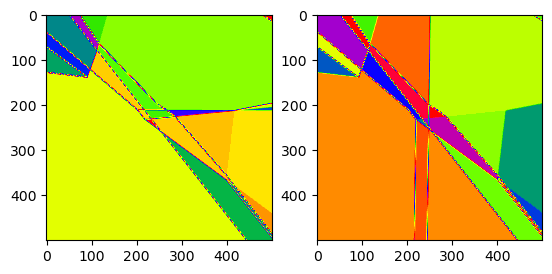

In [49]:
deep_gradient = np.gradient(deep_val)

fig, ax = plt.subplots(1, 2)
for i in range(2):
    ax[i].imshow(deep_gradient[i], cmap=mpl.colormaps['prism'])

plt.show()